# Gait classification

## Libraries and directory

In [1]:
#import packages, there might be some extras
import os
import platform
import csv
import re

import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc, accuracy_score, precision_recall_curve
from sklearn.preprocessing import LabelEncoder
import keras.utils
from tensorflow.keras import regularizers

import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.grid'] = True
plt.rcParams['legend.fontsize'] = 'large'



2024-02-15 11:25:50.532648: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
if platform.system() == "Darwin":
    root_directory = '/Users/lorenzobarbiero/Documents/GitHub/CNN-Gait-recognition'
else:
    from google.colab import drive
    drive.mount('/content/drive')
    root_directory = '/content/drive/MyDrive/Human_Data/Progetto'
    # root_directory = '/content/drive/MyDrive/Progetto'
    # root_directory = '/content/drive/MyDrive/Progetto'

print('root directory is ' + root_directory)

root directory is /Users/lorenzobarbiero/Documents/GitHub/CNN-Gait-recognition


## Fix naming for the files and create a reference document

In [ ]:
def add_folder_to_filename(directory):
    # Iterate through all files and directories in the given directory
    for root, dirs, files in os.walk(directory):
        # Exclude .DS_Store files
        if '.DS_Store' in files:
            files.remove('.DS_Store')

        for file in files:
            # Generate the relative path of the file from the root directory
            relative_path = os.path.relpath(root, directory)

            # Replace '/' with '_' in the relative path


            # Construct the new filename by appending the modified relative path
            new_filename = os.path.join(relative_path, file)

            new_filename = new_filename.replace(os.sep, '_')
            new_filename = new_filename.replace("subject", "Sbj").replace("trial", "T").replace("pressure", "P").replace("skeleton", "S")

            # Construct the full paths for the old and new filenames
            old_path = os.path.join(root, file)
            new_path = os.path.join(root, new_filename)

            # Rename the file
            os.rename(old_path, new_path)
            print(f"Renamed '{old_path}' to '{new_path}'")

Apply the function to the "dataset" folder

DO NOT RUN THE NEXT CELL

In [ ]:
# # Specify the directory where you want to start renaming files
# directory = root_directory + '/Dataset'

# # Call the function to add folder names to filenames
# add_folder_to_filename(directory)

Prepare the reference file

In [ ]:
gait = np.array(['antalgic', 'lurching', 'normal', 'steppage', 'stifflegged', 'trendelenburg'])
num_gait = np.arange(6)

def compile_csv(root_directory):
    # Open the CSV file in write mode
    with open(root_directory+'/reference_document.csv', 'w', newline='') as csvfile:
        # Define the CSV writer
        csv_writer = csv.writer(csvfile)
        # Write the header row
        csv_writer.writerow(['File_Name', 'Path_from_Root', 'Type', 'Label_str', 'Label'])

        # Iterate through all files and directories in the given directory
        directory = root_directory + '/dataset'
        for root, dirs, files in os.walk(directory):
            # Exclude .DS_Store files
            if '.DS_Store' in files:
                files.remove('.DS_Store')

            for file in files:
                # Extract information from the filename
                filename, ext = os.path.splitext(file)
                path_from_root = os.path.relpath(root, directory)
                type_ = "pressure" if filename[-1] == "P" else "skeleton"

                # Replace specific substrings in the filename
                label = filename.replace("Sbj","").replace("T","").replace("P","").replace("S","")

                # Remove non-alphanumeric characters and underscores
                label = re.sub(r'[^\w\s]|_', '', label)
                label = re.sub(r'\d', '', label)

                label_num = num_gait[np.where(gait==label)].item()

                # Write the information to the CSV file
                csv_writer.writerow([filename + '.csv', path_from_root+"/", type_, label, label_num])


compile_csv(root_directory)

## Prepare the reference dataframe
Import the dataframe

In [3]:
reference_df = pd.read_csv(root_directory+'/reference_document.csv',
                           header=None, names=['Name_file', 'Path_from_Root', 'Type_of_data', 'Type_of_gait', 'Label'])

reference_df = reference_df.iloc[1:]
reference_df['Label'] = reference_df['Label'].astype(int)

reference_df

,Name_file,Path_from_Root,Type_of_data,Type_of_gait,Label
1,Sbj2_steppage_T9_P.csv,subject2/steppage/trial9/,pressure,steppage,3
2,Sbj2_steppage_T9_S.csv,subject2/steppage/trial9/,skeleton,steppage,3
3,Sbj2_steppage_T14_P.csv,subject2/steppage/trial14/,pressure,steppage,3
4,Sbj2_steppage_T14_S.csv,subject2/steppage/trial14/,skeleton,steppage,3
5,Sbj2_steppage_T13_S.csv,subject2/steppage/trial13/,skeleton,steppage,3
...,...,...,...,...,...
2876,Sbj9_trendelenburg_T11_S.csv,subject9/trendelenburg/trial11/,skeleton,trendelenburg,5
2877,Sbj9_trendelenburg_T18_S.csv,subject9/trendelenburg/trial18/,skeleton,trendelenburg,5
2878,Sbj9_trendelenburg_T18_P.csv,subject9/trendelenburg/trial18/,pressure,trendelenburg,5
2879,Sbj9_trendelenburg_T20_S.csv,subject9/trendelenburg/trial20/,skeleton,trendelenburg,5


Edit for later use

In [4]:
def complete_path(row):
  complete_path = root_directory + '/dataset/' + row['Path_from_Root'] + row['Name_file']
  return complete_path

reference_df['Complete_path'] = reference_df.apply(complete_path, axis=1)
reference_df.set_index('Complete_path', inplace=True)
reference_df = reference_df.drop(columns=['Path_from_Root'])
reference_df

,Name_file,Type_of_data,Type_of_gait,Label
Complete_path,,,,
/Users/lorenzobarbiero/Documents/GitHub/CNN-Gait-recognition/dataset/subject2/steppage/trial9/Sbj2_steppage_T9_P.csv,Sbj2_steppage_T9_P.csv,pressure,steppage,3
/Users/lorenzobarbiero/Documents/GitHub/CNN-Gait-recognition/dataset/subject2/steppage/trial9/Sbj2_steppage_T9_S.csv,Sbj2_steppage_T9_S.csv,skeleton,steppage,3
/Users/lorenzobarbiero/Documents/GitHub/CNN-Gait-recognition/dataset/subject2/steppage/trial14/Sbj2_steppage_T14_P.csv,Sbj2_steppage_T14_P.csv,pressure,steppage,3
/Users/lorenzobarbiero/Documents/GitHub/CNN-Gait-recognition/dataset/subject2/steppage/trial14/Sbj2_steppage_T14_S.csv,Sbj2_steppage_T14_S.csv,skeleton,steppage,3
/Users/lorenzobarbiero/Documents/GitHub/CNN-Gait-recognition/dataset/subject2/steppage/trial13/Sbj2_steppage_T13_S.csv,Sbj2_steppage_T13_S.csv,skeleton,steppage,3
...,...,...,...,...
/Users/lorenzobarbiero/Documents/GitHub/CNN-Gait-recognition/dataset/subject9/trendelenburg/trial11/Sbj9_trendelenburg_T11_S.csv,Sbj9_trendelenburg_T11_S.csv,skeleton,trendelenburg,5
/Users/lorenzobarbiero/Documents/GitHub/CNN-Gait-recognition/dataset/subject9/trendelenburg/trial18/Sbj9_trendelenburg_T18_S.csv,Sbj9_trendelenburg_T18_S.csv,skeleton,trendelenburg,5
/Users/lorenzobarbiero/Documents/GitHub/CNN-Gait-recognition/dataset/subject9/trendelenburg/trial18/Sbj9_trendelenburg_T18_P.csv,Sbj9_trendelenburg_T18_P.csv,pressure,trendelenburg,5


Split into skeleton and pressure dataframes

In [5]:
#split the dataframe into skeleton and pressure, drop the type column

reference_df_s = reference_df[reference_df['Type_of_data']=='skeleton']
reference_df_s = reference_df_s.drop(columns=['Type_of_data', 'Type_of_gait'])

reference_df_p = reference_df[reference_df['Type_of_data']=='pressure']
reference_df_p = reference_df_p.drop(columns=['Type_of_data', 'Type_of_gait'])

## Train/Test split
There's the option to perform either simple fractional train/test split or to perform leave one out train/test split

In [6]:
#index of the subject for validation [1,12], if None then random train/test split
leave_one_out = 3   

if leave_one_out == None:
    print("Random train/test splitting ", '\n')
    train_s, val_s = train_test_split(reference_df_s, test_size=0.2, stratify=reference_df_s['Label'], random_state=123)
    train_p, val_p = train_test_split(reference_df_p, test_size=0.2, stratify=reference_df_p['Label'], random_state=123)

else:
    print("Leaving out subject ", leave_one_out, '\n')
    string = "Sbj" + str(leave_one_out)
    train_s = reference_df_s[~reference_df_s['Name_file'].str.startswith(string)]
    val_s = reference_df_s[reference_df_s['Name_file'].str.startswith(string)]

    train_p = reference_df_p[~reference_df_p['Name_file'].str.startswith(string)]
    val_p = reference_df_p[reference_df_p['Name_file'].str.startswith(string)]
    
    
train_s = train_s.drop(columns=['Name_file'])
val_s = val_s.drop(columns=['Name_file'])
train_p = train_p.drop(columns=['Name_file'])
val_p = val_p.drop(columns=['Name_file'])


#frequence counts
print("Training Skeleton")
print(train_s['Label'].value_counts())
print('\n',"Validation Skeleton")
print(val_s['Label'].value_counts())
print('\n',"Train Pressure")
print(train_p['Label'].value_counts())
print('\n',"Validation Pressure")
print(val_p['Label'].value_counts())

Leaving out subject  3 

Training Skeleton
3    220
0    220
4    220
1    220
2    220
5    220
Name: Label, dtype: int64

 Validation Skeleton
3    20
0    20
4    20
1    20
2    20
5    20
Name: Label, dtype: int64

 Train Pressure
3    220
0    220
4    220
1    220
2    220
5    220
Name: Label, dtype: int64

 Validation Pressure
3    20
0    20
4    20
1    20
2    20
5    20
Name: Label, dtype: int64


## Skeleton data: load and preprocessing
Loading function

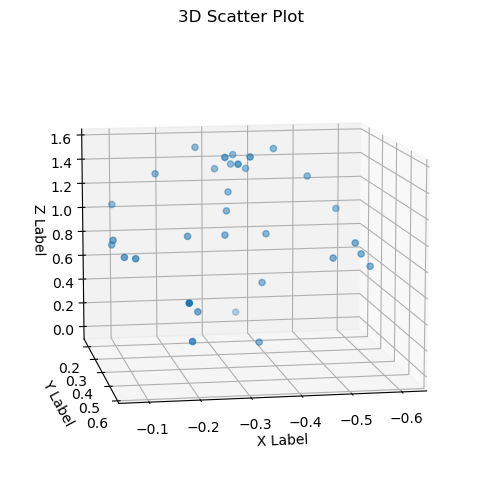

In [7]:
def load_data_sk(complete_path, load=True):

  if load:
    complete_path = complete_path.decode()

  df_skelly = pd.read_csv(complete_path, header=None)
  df_skelly = df_skelly.drop([df_skelly.columns[0],df_skelly.columns[-1]], axis=1)

  #convert to np array and reshape
  data = df_skelly.to_numpy().reshape((-1,32,3))
  return data.squeeze()


# Example
sk_data = load_data_sk(train_s.index[1], load=False)

#plot example, select only one frame
plotdata = sk_data[150]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(plotdata[:, 0], plotdata[:, 1], plotdata[:, 2])
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.set_title('3D Scatter Plot')
ax.view_init(elev=10, azim=80)
plt.show()

Normalization function

Data is normalized axis wise

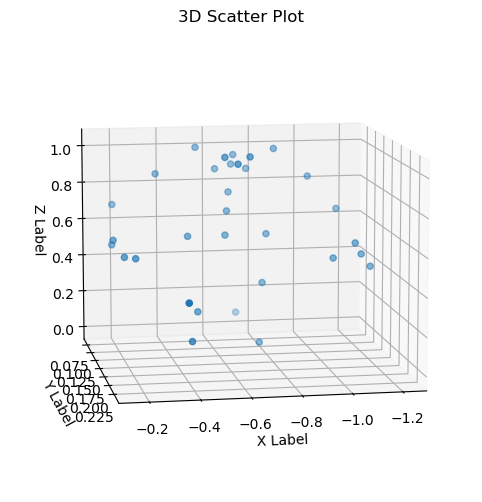

In [8]:
def normalize_data_sk(data):
    # Amplitude estimate for each axes
    norm_factor_x = np.percentile(data[:, :, 0], 95) - np.percentile(data[:, :, 0], 5)
    norm_factor_y = np.percentile(data[:, :, 1], 95) - np.percentile(data[:, :, 1], 5)
    norm_factor_z = np.percentile(data[:, :, 2], 95) - np.percentile(data[:, :, 2], 5)

    data[:, :, 0] = data[:, :, 0] / norm_factor_x
    data[:, :, 1] = data[:, :, 1] / norm_factor_y
    data[:, :, 2] = data[:, :, 2] / norm_factor_z

    return data


# Example
sk_data = load_data_sk(train_s.index[1], load=False)
sk_data_norm = normalize_data_sk(sk_data)


#plot example, select only one frame
plotdata = sk_data[150]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(plotdata[:, 0], plotdata[:, 1], plotdata[:, 2])
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.set_title('3D Scatter Plot')
ax.view_init(elev=10, azim=80)
plt.show()

Crop function

In [9]:
def random_crop(data, target_size=50, noise_time=20, center_crop=False):

  # remove initial and final frames that we consider as noise
  start = noise_time
  end = data.shape[0] - noise_time

  data = data[start:end, :]

  N = data.shape[0]

  # Random Crop (always centered if center_crop=True)
  if center_crop:
      from_ = int((N / 2) - (target_size / 2))
      # print('Start of the crop: ', from_)
  else:
      from_ = np.random.randint(0, np.floor(N - target_size))
      # print('Start of the crop: ', from_)

  return data[from_:from_ + target_size]


# Example
sk_data = load_data_sk(train_s.index[1], load=False)

sk_data_crop = random_crop(sk_data)
print('Original shape ', sk_data.shape, 'Cropped/Padded shape ', sk_data_crop.shape)

Original shape  (274, 32, 3) Cropped/Padded shape  (50, 32, 3)


Unique load and preprocessing function

In [10]:
def load_prep_sk(complete_path):
    data = load_data_sk(complete_path, load=True)
    data = normalize_data_sk(data)

    # correct shape for later training
    data = data.reshape(data.shape[0], -1)

    return data.astype(np.float32)

## Skeleton data: Tensorflow dataset
Two options have been explored, direct RNN based classifier or RNN autoencoder, this results in the need for two slightly different tensorflow datasets

#### Classifier

In [11]:
def create_dataset_sk(table, cache_file, shuffle, batch_size, target_size=50, noise_time=20, center_crop=False):

  # shape
  input_size = (target_size, 96)

  # Convert dataframe to lists
  file_names = list(table.index)
  labels = table['Label']

  # Create a Dataset object
  dataset = tf.data.Dataset.from_tensor_slices((file_names, labels))

  # Shuffle
  if shuffle:
      dataset = dataset.shuffle(len(file_names))

  # Map the load_and_preprocess_data function
  py_func = lambda path, label: (tf.numpy_function(load_prep_sk, [path], tf.float32), label)
  dataset = dataset.map(py_func, num_parallel_calls=os.cpu_count())

  # Cache dataset
  if cache_file:
      dataset = dataset.cache(cache_file)

  # Repeat the dataset indefinitely
  dataset = dataset.repeat()

  # Map the crop function
  py_func = lambda data, label: (tf.ensure_shape(tf.numpy_function(random_crop, [data, target_size, noise_time, center_crop], tf.float32),
                                              input_size), label)
  dataset = dataset.map(py_func, num_parallel_calls=os.cpu_count())

  # Batch
  dataset = dataset.batch(batch_size=batch_size)

  # Prefetch
  dataset = dataset.prefetch(buffer_size=1)

  return dataset

Dataset inizialization

In [12]:
batch_s = 30

dataset_train_s = create_dataset_sk(table = train_s,
                                    cache_file = 'train_s_cache',
                                    shuffle = True,
                                    batch_size = batch_s,
                                    target_size = 50,
                                    noise_time = 20,
                                    center_crop = False)

dataset_val_s = create_dataset_sk(table = val_s,
                                    cache_file = 'val_s_cache',
                                    shuffle = False,
                                    batch_size = batch_s,
                                    target_size = 50,
                                    noise_time = 20,
                                    center_crop = False)

train_steps_s = int(np.ceil(len(train_s)/batch_s))
val_steps_s = int(np.ceil(len(val_s)/batch_s))

2024-02-15 11:26:17.447214: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Autoencoder

In [13]:
def create_dataset_autoencoders_sk(table, cache_file, shuffle, batch_size, target_size=50, noise_time=20, center_crop=False):

  # shape
  input_size = (target_size, 96)

  # Convert dataframe to lists
  file_names = list(table.index)

  # Create a Dataset object
  dataset = tf.data.Dataset.from_tensor_slices((file_names))

  # Shuffle
  if shuffle:
      dataset = dataset.shuffle(len(file_names))

  # Map the load_and_preprocess_data function
  py_func = lambda path: (tf.numpy_function(load_prep_sk, [path], tf.float32))
  dataset = dataset.map(py_func, num_parallel_calls=os.cpu_count())

  # Cache dataset
  if cache_file:
      dataset = dataset.cache(cache_file)

  # Repeat the dataset indefinitely
  dataset = dataset.repeat()

  # Map the crop function
  py_func = lambda data: (tf.ensure_shape(tf.numpy_function(random_crop, [data, target_size, noise_time, center_crop], tf.float32), input_size))
  dataset = dataset.map(py_func, num_parallel_calls=os.cpu_count())

  # After the cache to be sure that they have the same data
  # Duplicate data for the autoencoder (input = output)
  py_funct = lambda data: (data, data)
  dataset = dataset.map(py_funct)

  # Batch
  dataset = dataset.batch(batch_size=batch_size)

  # Prefetch
  dataset = dataset.prefetch(buffer_size=1)

  return dataset

Dataset initialization

In [14]:
batch_s = 30

dataset_train_s_autoencoder = create_dataset_autoencoders_sk(table = train_s,
                                    cache_file = 'train_s_cache_autoencoder',
                                    shuffle = True,
                                    batch_size = batch_s,
                                    target_size = 50,
                                    noise_time = 20,
                                    center_crop = False)

dataset_val_s_autoencoder = create_dataset_autoencoders_sk(table = val_s,
                                    cache_file = 'val_s_cache_autoencoder',
                                    shuffle = False,
                                    batch_size = batch_s,
                                    target_size = 50,
                                    noise_time = 20,
                                    center_crop = False)


train_steps_s = int(np.ceil(len(train_s)/batch_s))
val_steps_s = int(np.ceil(len(val_s)/batch_s))

first_element_dataset_k = dataset_train_s_autoencoder.take(1)
first_element_dataset_k

for d, l in first_element_dataset_k:
  print(d.numpy().shape, l.numpy().shape)
  print(np.array_equal(d.numpy(), l.numpy()))

(30, 50, 96) (30, 50, 96)
True


2024-02-15 11:26:23.139016: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


## Skeleton data: RNN

#### Classifier

In [15]:
def MyModel_RNN(time_length, n_features):

  X_input = tf.keras.Input((time_length, 96))

  # Linear_part
  x = tf.keras.layers.Dense(units=n_features, activation='relu', input_shape=(time_length, n_features))(X_input)

  # RNN part
  # h(t) = tanh(W_hx * x(t) + W_hh * h(t-1) + bias)
  x = tf.keras.layers.GRU(125, return_sequences=True, activation='tanh', name='I_GRU')(x)

  x = tf.keras.layers.GRU(125, return_sequences=True, activation='tanh', name='II_GRU')(x)
  x = tf.keras.layers.GRU(125, return_sequences=True, activation='tanh', name='III_GRU')(x)
  x = tf.keras.layers.GRU(125, return_sequences=False, activation='tanh', name='IV_GRU')(x)

  # Flatten_output
  x = tf.keras.layers.Flatten()(x)                                                                       # serve davvero il flatten?

  # Linear part
  x = tf.keras.layers.Dense(64, activation='relu', name='I_layer')(x)
  x = tf.keras.layers.Dense(32, activation='relu', name='II_layer')(x)
  x = tf.keras.layers.Dense(16, activation='relu', name='III_layer')(x)

  # Last layer
  RNN_outputs = tf.keras.layers.Dense(6, activation='softmax', name='Output_layer')(x)

  # Create model
  model = tf.keras.Model(inputs = X_input, outputs = RNN_outputs, name='RNN_model')

  return model

Compile the model

In [16]:
RNN_classifier = MyModel_RNN(50, 96)
RNN_classifier.compile(
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

RNN_classifier.summary()

Model: "RNN_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 96)]          0         
                                                                 
 dense (Dense)               (None, 50, 96)            9312      
                                                                 
 I_GRU (GRU)                 (None, 50, 125)           83625     
                                                                 
 II_GRU (GRU)                (None, 50, 125)           94500     
                                                                 
 III_GRU (GRU)               (None, 50, 125)           94500     
                                                                 
 IV_GRU (GRU)                (None, 125)               94500     
                                                                 
 flatten (Flatten)           (None, 125)               0 

Train and save the model

In [17]:
# Train the model
num_epochs = 1

early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                       patience=5)

# Fit the model
history = RNN_classifier.fit(dataset_train_s,
                                   epochs=num_epochs,
                                   steps_per_epoch=train_steps_s,
                                   validation_data=dataset_val_s,
                                   validation_steps=val_steps_s,
                                   callbacks=[early_stop_callback])


RNN_classifier.save('./trained_models/RNN_classifier.h5')

44/44 [==============================] - 9s 113ms/step - loss: 1.7825 - accuracy: 0.2008 - val_loss: 1.7925 - val_accuracy: 0.2000


In [ ]:
# Plot loss
plt.figure()
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plot accuracy
plt.figure()
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Val accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

Load the model (if needed)

In [18]:
load_model_rnn_cl = False

if load_model_rnn_cl ==True:
    path_RNN_cl = root_directory + './trained_models/RNN_classifier.h5'
    CNN_classifier = keras.models.load_model(path_RNN_cl)

#### Autoencoder

Define the model

In [19]:
def RNN_autoencoder(time_length, latent_dim, code_size):

    # encoder
    encoder = tf.keras.Sequential()
    encoder.add(tf.keras.Input((time_length, 96)))

    encoder.add(tf.keras.layers.GRU(latent_dim, return_sequences=True, activation='tanh', name='I_GRU'))
    encoder.add(tf.keras.layers.GRU(latent_dim, return_sequences=True, activation='tanh', name='II_GRU'))

    encoder.add(tf.keras.layers.GRU(latent_dim, return_sequences=True, activation='tanh', name='III_GRU'))
    encoder.add(tf.keras.layers.GRU(code_size, return_sequences=False, activation='tanh', name='IV_GRU'))

    # encoder.add(tf.keras.layers.Dense(code_size))

    # decoder
    decoder = tf.keras.Sequential()
    decoder.add(tf.keras.Input((code_size,)))

    decoder.add(tf.keras.layers.RepeatVector(time_length))
    decoder.add(tf.keras.layers.GRU(96, return_sequences=True, activation='tanh', name='decoder_GRU'))

    return encoder, decoder


encoder_rnn, decoder_rnn = RNN_autoencoder(time_length=50, latent_dim=225, code_size=125)
print(encoder_rnn.output_shape[1:])
print(decoder_rnn.output_shape[1:])
encoder_rnn.summary()
decoder_rnn.summary()

(125,)
(50, 96)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 I_GRU (GRU)                 (None, 50, 225)           218025    
                                                                 
 II_GRU (GRU)                (None, 50, 225)           305100    
                                                                 
 III_GRU (GRU)               (None, 50, 225)           305100    
                                                                 
 IV_GRU (GRU)                (None, 125)               132000    
                                                                 
Total params: 960,225
Trainable params: 960,225
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 repeat_vect

Compile the model

In [20]:
inp_seq = tf.keras.Input((50, 96))
code_rnn = encoder_rnn(inp_seq)
reconstruction_seq = decoder_rnn(code_rnn)

autoencoder_rnn = tf.keras.Model(inputs=inp_seq, outputs=reconstruction_seq)

autoencoder_rnn.compile(optimizer="adamax", loss='mse')

Train and save the model

In [21]:
num_epochs = 1

early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                       patience=5)

autoencoder_rnn.fit(dataset_train_s_autoencoder,
                epochs=num_epochs,
                steps_per_epoch=train_steps_s,
                validation_data=dataset_val_s_autoencoder,
                validation_steps=val_steps_s,
                callbacks=[early_stop_callback])

path_encoder_RNN = root_directory + './trained_models/encoder_RNN.h5'
path_decoder_RNN = root_directory + './trained_models/decoder_RNN.h5'

encoder_rnn.save(path_encoder_RNN)
decoder_rnn.save(path_decoder_RNN)

44/44 [==============================] - ETA: 0s - loss: 0.0463

2024-02-15 11:27:23.947770: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


44/44 [==============================] - 16s 254ms/step - loss: 0.0463 - val_loss: 0.0056


2024-02-15 11:27:25.541378: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Text(0, 0.5, 'Loss')

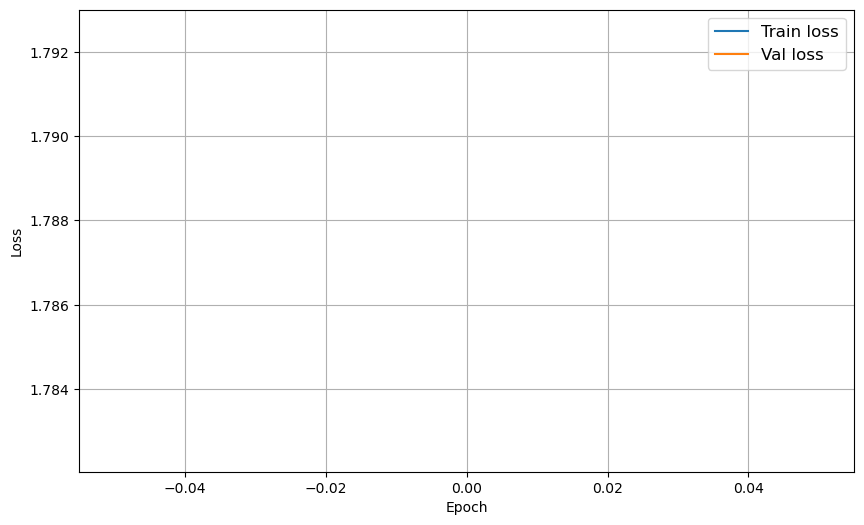

In [22]:
# Plot loss
plt.figure()
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

Load the model (if needed)

In [23]:
load_model_rnn_ae = False

if load_model_rnn_ae ==True:
    path_encoder_RNN = root_directory + './trained_models/encoder_RNN.h5'
    path_decoder_RNN = root_directory + './trained_models/decoder_RNN.h5'

    encoder_rnn = keras.models.load_model(path_encoder_RNN)
    decoder_rnn = keras.models.load_model(path_decoder_RNN)

## Skeleton data: results and optimization

#### Classifier

In [ ]:
# to do

#### Autoencoder

Plot an example of the output

1/1 [==============================] - 0s 35ms/step
(1, 125)
1/1 [==============================] - 0s 21ms/step


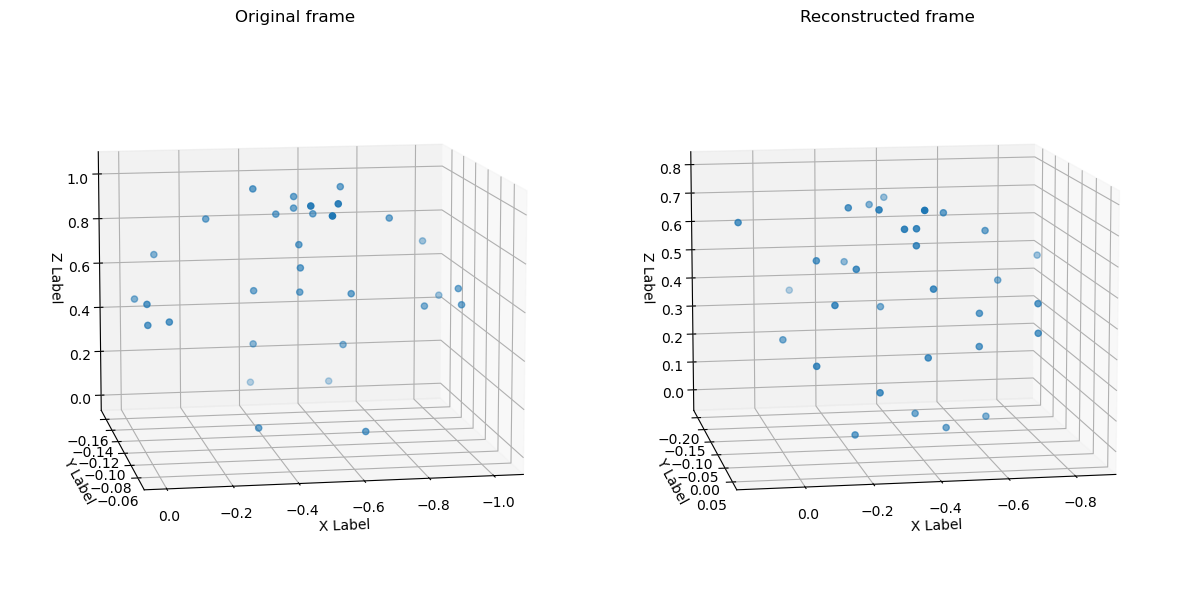

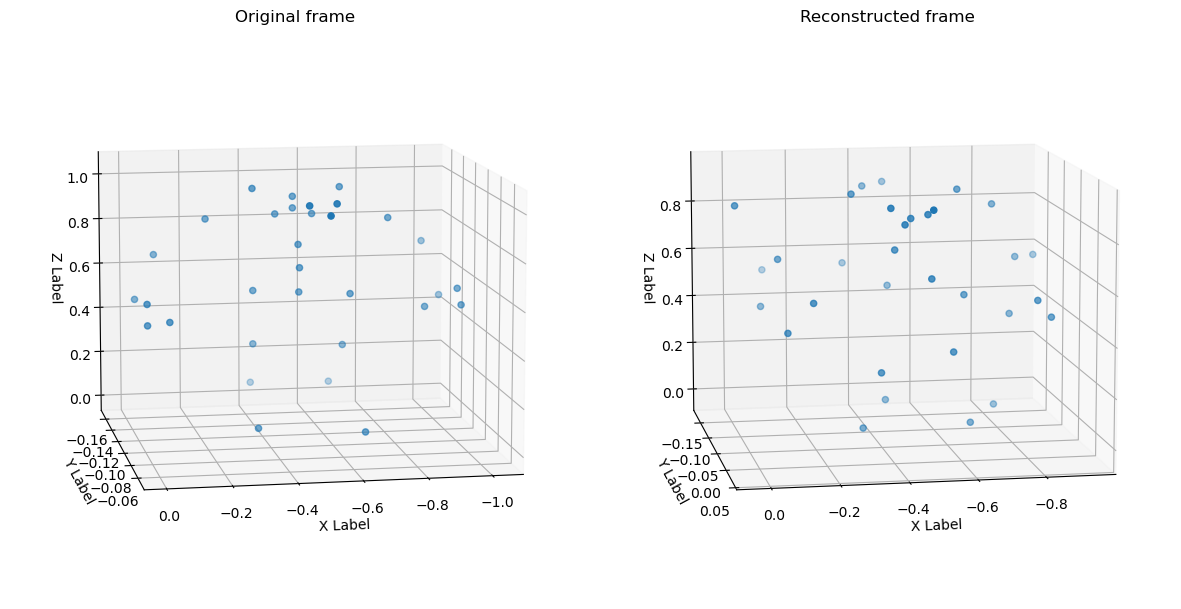

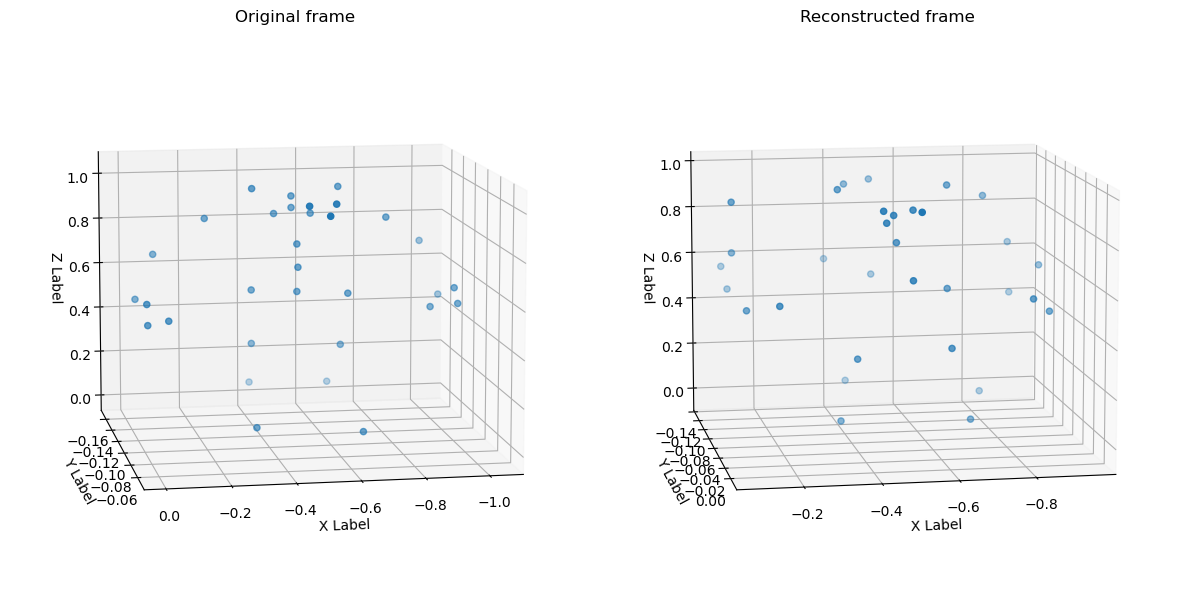

In [25]:
# Example

sk_data = load_data_sk(val_s.index[26], load=False)
sk_data_norm = normalize_data_sk(sk_data)

seq = sk_data_norm[10:60, :, :].reshape((50, -1))
seq_input = seq[np.newaxis, :]

code = encoder_rnn.predict(seq_input)
print(code.shape)
reco = decoder_rnn.predict(code).reshape((50, 96))

for time in range(3):
  t = time
  frame_input = seq[t, :].reshape((32, -1))
  frame_output = reco[t, :].reshape((32, -1))
  # print(frame_input.shape)
  # print(frame_output.shape)


  fig, axes = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': '3d'})

  # First subplot (frame_input)
  ax1 = axes[0]
  ax1.scatter(frame_input[:, 0], frame_input[:, 1], frame_input[:, 2])
  ax1.set_xlabel('X Label')
  ax1.set_ylabel('Y Label')
  ax1.set_zlabel('Z Label')
  ax1.set_title('Original frame')
  ax1.view_init(elev=10, azim=80)

  # Second subplot (frame_output)
  ax2 = axes[1]
  ax2.scatter(frame_output[:, 0], frame_output[:, 1], frame_output[:, 2])
  ax2.set_xlabel('X Label')
  ax2.set_ylabel('Y Label')
  ax2.set_zlabel('Z Label')
  ax2.set_title('Reconstructed frame')
  ax2.view_init(elev=10, azim=80)

  plt.tight_layout()
  plt.show()
  print('\n', '\n')


Look for the best hyperparameters with a benchmarking function

In [ ]:
def benchmark_rnn(code_size, latent_dim):
    print("Validation loss for code_size= ", code_size, 'and latent dimension ', latent_dim)
    encoder_rnn, decoder_rnn = RNN_autoencoder(time_length=50, latent_dim=225, code_size=125)
    
    inp_seq = tf.keras.Input((50, 96))
    code_rnn = encoder_rnn(inp_seq)
    reconstruction_seq = decoder_rnn(code_rnn)

    autoencoder_rnn = tf.keras.Model(inputs=inp_seq, outputs=reconstruction_seq)
    autoencoder_rnn.compile(optimizer="adamax", loss='mse')
    
    early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                       patience=5)

    autoencoder_rnn.fit(dataset_train_s_autoencoder,
                    epochs=num_epochs,
                    steps_per_epoch=train_steps_s,
                    validation_data=dataset_val_s_autoencoder,
                    validation_steps=val_steps_s,
                    callbacks=[early_stop_callback], verbose=0)
    
    print('Validation loss =', autoencoder_rnn.evaluate(dataset_val_s_autoencoder,steps=val_steps_s))

In [ ]:
code_size_list = [8,16,32,64,128]
latdim_list = [64,128,256]

for i in latdim_list:
    for j in code_size_list:
        benchmark_rnn(j,i)

## Pressure data: load and preprocessing

Loading function

In [26]:
def load_data_ps(complete_path, load=True):

  if load:
    complete_path = complete_path.decode()

  pressure_data = pd.read_csv(complete_path, header=None).to_numpy()

  return pressure_data.squeeze()

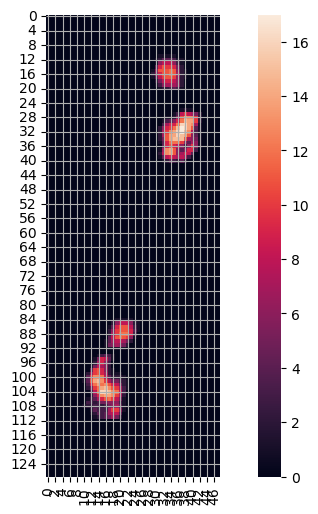

In [27]:
# Example
ps_data = load_data_ps(train_p.index[330], load=False)

sns.heatmap(ps_data, square= True)
plt.show()

Normalization

In [28]:
def normalize_data_ps(data):
    max_data = np.max(data)
    data = data / max_data
    return data

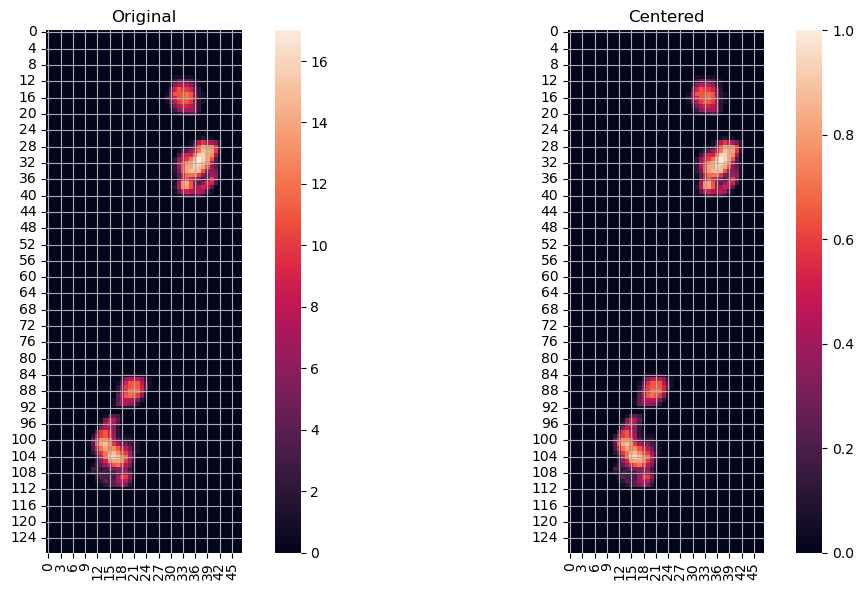

In [29]:
# Example
ps_data = load_data_ps(train_p.index[330], load=False)
ps_data_norm = normalize_data_ps(ps_data)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

#first heatmap
sns.heatmap(ps_data, square=True, ax=axes[0])
axes[0].set_title('Original')
#second heatmap
sns.heatmap(ps_data_norm, square=True,ax=axes[1])
axes[1].set_title('Normalized')

plt.tight_layout()
plt.show()

Centering function

In [30]:
def barycenter(data, debug = False):
    # Compute the weighted average (barycenter) along each dimension
    y_barycenter = np.average(np.arange(data.shape[0]), weights=np.sum(data, axis=1))
    x_barycenter = np.average(np.arange(data.shape[1]), weights=np.sum(data, axis=0))
    
    # Compute the distances between each point and the barycenter
    shift_x = -(x_barycenter - data.shape[1]/2)
    shift_y = -(y_barycenter - data.shape[0]/2)
    
    # Shift the foot pressure matrix to be centered on the barycenter
    shifted_matrix = np.roll(data, int(shift_x), axis=1)
    shifted_matrix = np.roll(shifted_matrix, int(shift_y), axis=0)

    if debug == True:
        y_barycenter_after = np.average(np.arange(shifted_matrix.shape[0]), weights=np.sum(shifted_matrix, axis=1))
        x_barycenter_after = np.average(np.arange(shifted_matrix.shape[1]), weights=np.sum(shifted_matrix, axis=0))
        print("Barycenter coordinates (x,y) after = ", x_barycenter_after, y_barycenter_after, '\n')


    return shifted_matrix

Barycenter coordinates (x,y) after =  24.02523240371846 63.17729083665338 



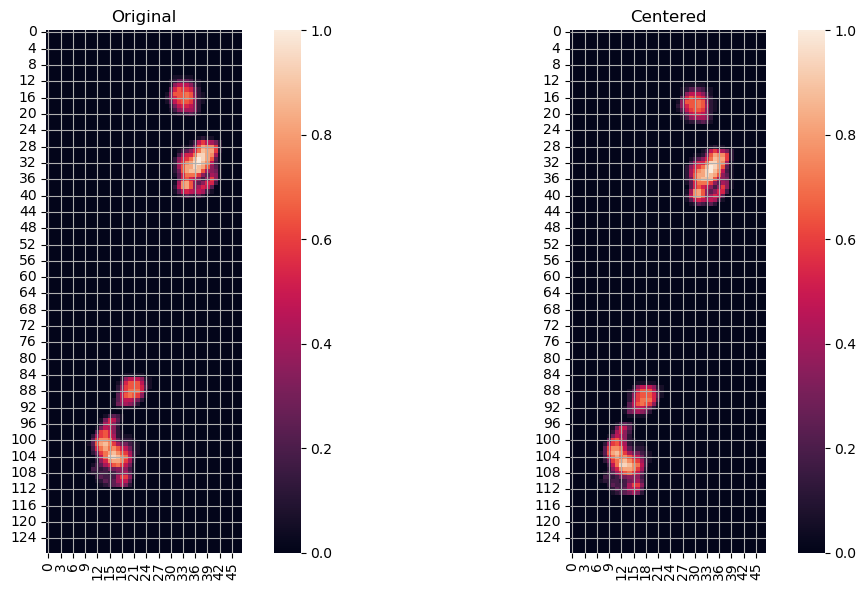

In [32]:
# Example
ps_data = load_data_ps(train_p.index[330], load=False)
ps_data_norm = normalize_data_ps(ps_data)
cen_ps_data_norm = barycenter(ps_data_norm, debug=True)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

#first heatmap
sns.heatmap(ps_data_norm, square=True, ax=axes[0])
axes[0].set_title('Original')
#second heatmap
sns.heatmap(cen_ps_data_norm, square=True,ax=axes[1])
axes[1].set_title('Centered')

plt.tight_layout()
plt.show()

Unique load and preprocessing function

In [33]:
def load_prep_ps(complete_path, load=True):
    data = load_data_ps(complete_path, load)
    data = normalize_data_ps(data)
    data = barycenter(data)

    return data.astype(np.float32)

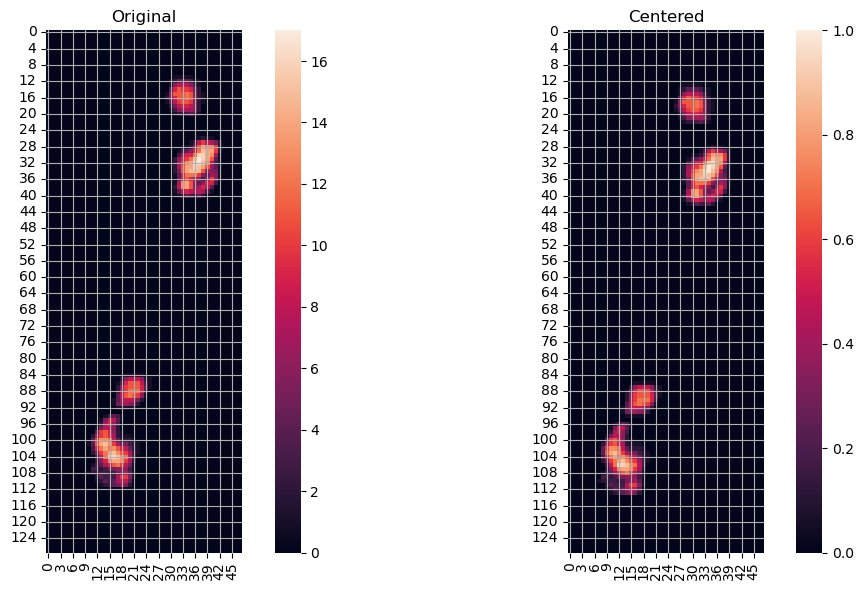

In [34]:
# Example
ps_data = load_data_ps(train_p.index[330], load=False)
ps_data_end = load_prep_ps(train_p.index[330], load=False)


fig, axes = plt.subplots(1, 2, figsize=(12, 6))

#first heatmap
sns.heatmap(ps_data, square=True, ax=axes[0])
axes[0].set_title('Original')
#second heatmap
sns.heatmap(ps_data_end, square=True,ax=axes[1])
axes[1].set_title('Centered')

plt.tight_layout()
plt.show()

## Pressure data: Tensorflow dataset

#### Classifier

In [48]:
def create_dataset_ps(table, cache_file, shuffle, batch_size):

  # Convert dataframe to lists
  file_names = list(table.index)
  labels = table['Label']

  # Create a Dataset object
  dataset = tf.data.Dataset.from_tensor_slices((file_names, labels))

  # Shuffle
  if shuffle:
      dataset = dataset.shuffle(len(file_names))

  # Map the load_and_preprocess_data function
  py_func = lambda path, label: (tf.numpy_function(load_prep_ps, [path], tf.float32), label)
  dataset = dataset.map(py_func, num_parallel_calls=os.cpu_count())

  # Cache dataset
  if cache_file:
      dataset = dataset.cache(cache_file)

  # Repeat the dataset indefinitely
  dataset = dataset.repeat()

  # Correct input shape for the network
  dataset = dataset.map(lambda img, label: (tf.expand_dims(img, 2), label))

  # Batch
  dataset = dataset.batch(batch_size=batch_size)

  # Prefetch
  dataset = dataset.prefetch(buffer_size=1)

  return dataset

Dataset inizialization

In [49]:
batch_p = 20

dataset_train_p = create_dataset_ps(table = train_p,
                                    cache_file = 'train_p_cache',
                                    shuffle = True,
                                    batch_size = batch_p)

dataset_val_p = create_dataset_ps(table = val_p,
                                    cache_file = 'val_p_cache',
                                    shuffle = False,
                                    batch_size = batch_p)

train_steps_p = int(np.ceil(len(train_p)/batch_p))
val_steps_p = int(np.ceil(len(val_p)/batch_p))

#### Autoencoder

In [37]:
def create_dataset_autoencoder_ps(table, cache_file, shuffle, batch_size, ):

  # Convert dataframe to lists
  file_names = list(table.index)

  # Create a Dataset object
  dataset = tf.data.Dataset.from_tensor_slices((file_names))

  # Shuffle
  if shuffle:
      dataset = dataset.shuffle(len(file_names))

  # Map the load_and_preprocess_data function
  py_func = lambda path: (tf.numpy_function(load_prep_ps, [path], tf.float32))
  dataset = dataset.map(py_func, num_parallel_calls=os.cpu_count())

  # Duplicate data for the autoencoder (input = output)
  py_funct = lambda img: (img, img)
  dataset = dataset.map(py_funct)

  # Cache dataset
  if cache_file:
      dataset = dataset.cache(cache_file)

  # Repeat the dataset indefinitely
  dataset = dataset.repeat()

  # Correct input shape for the network
  dataset = dataset.map(lambda img_1, img_2: (tf.expand_dims(img_1, 2), (tf.expand_dims(img_2, 2))))

  # Batch
  dataset = dataset.batch(batch_size=batch_size)

  # Prefetch
  dataset = dataset.prefetch(buffer_size=1)

  return dataset

Dataset inizialization

In [39]:
batch_p = 20

dataset_train_p_autoencoder = create_dataset_autoencoder_ps(table = train_p,
                                    cache_file = 'train_p_cache_autoencoder',
                                    shuffle = True,
                                    batch_size = batch_p)

dataset_val_p_autoencoder = create_dataset_autoencoder_ps(table = val_p,
                                    cache_file = 'val_p_cache_autoencoder',
                                    shuffle = False,
                                    batch_size = batch_p)

train_steps_p = int(np.ceil(len(train_p)/batch_p))
val_steps_p = int(np.ceil(len(val_p)/batch_p))

## Pressure data: CNN

#### Classifier

In [40]:
def MyModel_CNN(side_1, side_2, side_3, weight_L2):

  CNN_inputs = tf.keras.Input(shape=(side_1, side_2, side_3))

  x = tf.keras.layers.Conv2D(filters = 32,
                            kernel_size = 3,
                            strides = 1,
                            padding = 'same',
                            activation = 'elu',
                            name='I_Conv2D', kernel_regularizer=regularizers.l2(weight_L2))(CNN_inputs)
  x = tf.keras.layers.MaxPool2D(pool_size = 2)(x)
  x = tf.keras.layers.BatchNormalization()(x)

  x = tf.keras.layers.Conv2D(64, 3, 1, padding='same', activation = 'elu', name='II_Conv2D',kernel_regularizer=regularizers.l2(weight_L2))(x)
  x = tf.keras.layers.MaxPool2D(2)(x)
  x = tf.keras.layers.BatchNormalization()(x)

  x = tf.keras.layers.Conv2D(128, 3, 1, padding='same', activation = 'elu', name='III_Conv2D',kernel_regularizer=regularizers.l2(weight_L2))(x)
  x = tf.keras.layers.MaxPool2D(2)(x)
  x = tf.keras.layers.BatchNormalization()(x) 
  x = tf.keras.layers.Dropout(0.1)(x)

  x = tf.keras.layers.Flatten()(x)

  x = tf.keras.layers.Dense(128, activation='elu', name='I_layer',kernel_regularizer=regularizers.l2(weight_L2))(x)  
  x = tf.keras.layers.Dense(64, activation='elu', name='II_layer',kernel_regularizer=regularizers.l2(weight_L2))(x)
  x = tf.keras.layers.Dense(32, activation='elu', name='III_layer',kernel_regularizer=regularizers.l2(weight_L2))(x)
  x = tf.keras.layers.Dense(16, activation='elu', name='IV_layer',kernel_regularizer=regularizers.l2(weight_L2))(x)
  x = tf.keras.layers.Dropout(0.1)(x)
                                                                                        
  CNN_outputs = tf.keras.layers.Dense(6, activation='softmax', name='Output_layer')(x)

  # Create model
  model = tf.keras.Model(inputs=CNN_inputs, outputs=CNN_outputs)

  return model

Compile the model

In [42]:
CNN_classifier = MyModel_CNN(128, 48, 1, 0.01)
CNN_classifier.compile(
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

CNN_classifier.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 128, 48, 1)]      0         
                                                                 
 I_Conv2D (Conv2D)           (None, 128, 48, 32)       320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 24, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_3 (Batc  (None, 64, 24, 32)       128       
 hNormalization)                                                 
                                                                 
 II_Conv2D (Conv2D)          (None, 64, 24, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 12, 64)       0   

Train and save the model

In [50]:
# Train the model
num_epochs = 20

early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy',
                                                       patience=10)

# Fit the model
history = CNN_classifier.fit(dataset_train_p,
                                   epochs=num_epochs,
                                   steps_per_epoch=train_steps_p,
                                   validation_data=dataset_val_p,
                                   validation_steps=val_steps_p,
                                   callbacks=[early_stop_callback])


CNN_classifier.save('./trained_models/CNN_classifier.h5')

Epoch 1/20
44/66 [===================>..........] - ETA: 2s - loss: 7.0923 - accuracy: 0.4148

KeyboardInterrupt: 

In [ ]:
# Plot loss
plt.figure()
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plot accuracy
plt.figure()
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Val accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

Load the model (if needed)

In [ ]:
load_model_cnn_cl = False

if load_model_cnn_cl ==True:
    path_CNN_cl = root_directory + './trained_models/CNN_classifier.h5'
    CNN_classifier = keras.models.load_model(path_CNN_cl)

#### Autoencoder

In [44]:
def CNN_autoencoder(img_shape, code_size):
    # encoder
    encoder = tf.keras.Sequential()
    encoder.add(tf.keras.Input(img_shape))

    encoder.add(tf.keras.layers.Conv2D(32, (3, 3), activation='elu', padding='same'))
    encoder.add(tf.keras.layers.MaxPool2D((2, 2), padding='same'))

    encoder.add(tf.keras.layers.Conv2D(64, (3, 3), activation='elu', padding='same'))
    encoder.add(tf.keras.layers.MaxPool2D((2, 2), padding='same'))

    encoder.add(tf.keras.layers.Conv2D(128, (3, 3), activation='elu', padding='same'))
    encoder.add(tf.keras.layers.MaxPool2D((2, 2), padding='same'))

    encoder.add(tf.keras.layers.Conv2D(256, (3, 3), activation='elu', padding='same'))
    encoder.add(tf.keras.layers.MaxPool2D((2, 2), padding='same'))

    encoder.add(tf.keras.layers.Flatten())
    encoder.add(tf.keras.layers.Dense(code_size))

    # decoder
    decoder = tf.keras.Sequential()
    decoder.add(tf.keras.Input((code_size,)))

    decoder.add(tf.keras.layers.Dense(8 * 3 * 256, activation='elu'))
    decoder.add(tf.keras.layers.Reshape((8, 3, 256)))
    decoder.add(tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(tf.keras.layers.Conv2DTranspose(32, (3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(tf.keras.layers.Conv2DTranspose(1, (3, 3), strides=2, activation=None, padding='same'))

    return encoder, decoder

input_shape = (128, 48, 1)
# print(input_shape)
encoder_cnn, decoder_cnn = CNN_autoencoder(input_shape, code_size=100)
# print(encoder_cnn.output_shape[1:])
# print(decoder_cnn.output_shape[1:])

encoder_cnn.summary()
decoder_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 48, 32)       320       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 64, 24, 32)       0         
 2D)                                                             
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 24, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 32, 12, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 12, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 16, 6, 128)      

Compile the model

In [45]:
inp_cnn = tf.keras.Input(input_shape)
code_cnn = encoder_cnn(inp_cnn)
reconstruction_cnn = decoder_cnn(code_cnn)

autoencoder_cnn = tf.keras.Model(inputs=inp_cnn, outputs=reconstruction_cnn)
autoencoder_cnn.compile(optimizer="adamax", loss='mse')

Train and save the model

In [46]:
# Train the model
num_epochs = 100

early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                        patience=5)

autoencoder_cnn.fit(dataset_train_p_autoencoder,
                    epochs=num_epochs,
                    steps_per_epoch=train_steps_p,
                    validation_data=dataset_val_p_autoencoder,
                    validation_steps=val_steps_p,
                    callbacks=[early_stop_callback])



path_encoder_CNN = root_directory + './trained_models/encoder_CNN.h5'
path_decoder_CNN = root_directory + './trained_models/decoder_CNN.h5'

encoder_cnn.save(path_encoder_CNN)
decoder_cnn.save(path_decoder_CNN)

Epoch 1/100


2024-02-15 11:32:39.367616: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 2/100


2024-02-15 11:32:40.181415: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


KeyboardInterrupt: 

Text(0, 0.5, 'Loss')

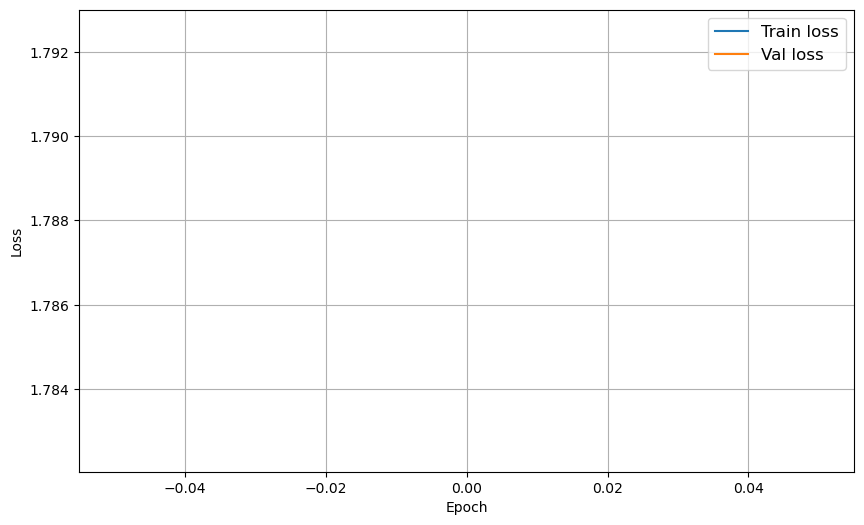

In [47]:
# Plot loss
plt.figure()
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

Load the model (if needed)

In [ ]:
load_model_cnn_ae = False

if load_model_rnn_ae ==True:
    path_encoder_CNN = root_directory + './trained_models/encoder_CNN.h5'
    path_decoder_CNN = root_directory + './trained_models/decoder_CNN.h5'

    encoder_cnn = keras.models.load_model(path_encoder_CNN)
    decoder_cnn = keras.models.load_model(path_decoder_CNN)

## Pressure data: results and optimizations

#### Classifier

In [ ]:
## to do

#### Autoencoder
Plot some results

In [ ]:
for i in np.arange(3):
  ps_data = load_data_ps(val_p.index[i], load=False)
  ps_data_norm = normalize_data_ps(ps_data)

  code = encoder_cnn.predict(ps_data_norm[np.newaxis, :])[0]
  reco = decoder_cnn.predict(code[None])[0]

  plt.subplot(1,3,1)
  plt.title("Original")
  plt.imshow(ps_data_norm)

  plt.subplot(1,3,2)
  plt.title("Code")
  plt.imshow(code.reshape([code.shape[-1]//2,-1]))

  plt.subplot(1,3,3)
  plt.title("Reconstructed")
  plt.imshow(reco)
  plt.show()

Look for the best hyperparameters with a benchmarking function

In [ ]:
def benchmark_cnn(code_size, optimizer):
    print("Validation loss for code_size =", code_size, 'and optimizer', optimizer)
    encoder_cnn, decoder_cnn = CNN_autoencoder(input_shape, code_size=code_size)
    
    inp_cnn = tf.keras.Input(input_shape)
    code_cnn = encoder_cnn(inp_cnn)
    reconstruction_cnn = decoder_cnn(code_cnn)

    autoencoder_cnn = tf.keras.Model(inputs=inp_cnn, outputs=reconstruction_cnn)

    autoencoder_cnn.compile(optimizer=optimizer, loss='mse')
    
    
    early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                       patience=5)

    autoencoder_cnn.fit(dataset_train_p_autoencoder,
                    epochs=num_epochs,
                    steps_per_epoch=train_steps_p,
                    validation_data=dataset_val_p_autoencoder,
                    validation_steps=val_steps_p,
                    callbacks=[early_stop_callback], verbose = 0)
    
    print('Validation loss = ', autoencoder_cnn.evaluate(dataset_val_p_autoencoder, steps=val_steps_p))

In [ ]:
code_size_list = [8,16,32,64,128]
optimizer_list = ['adamax','adam','rmsprop','sgd']

for i in optimizer_list:
    for j in code_size_list:
        benchmark_cnn(j,i)